In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [47]:
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mobius import SequenceGA, ScaffoldGA, GA
from mobius import DMTSimulation
from mobius.descriptors import Map4Fingerprint, SequenceDescriptors
from mobius.kernels import TanimotoSimilarityKernel
from mobius import expected_improvement, probability_of_improvement, greedy
from mobius import HELMGeneticOperators, compute_probability_matrix
from mobius import MHCIPeptideScorer
from mobius import energy_to_affinity_binding, affinity_binding_to_energy, plot_results

In [3]:
def plot_results(df, run_name):
    fig, axarr = plt.subplots(1, 2, sharex=True, figsize=(12.5, 7.5))

    for i in range(2):
        x = [-1, 0, 1, 2, 3, 4, 5, 6]
        axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='mM')] * len(x), '--', linewidth=1, color='lightgray')
        axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='uM')] * len(x), '--', linewidth=1, color='gray')
        axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='nM')] * len(x), '--', linewidth=1, color='black')
        axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='mM'), 'mM')
        axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='uM'), 'uM')
        axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='nM'), 'nM')

    # Average
    y = df.replace({'exp_score': 0.}, np.nan)\
      .groupby(by=['gen'])['exp_score']\
      .agg(['mean', 'std'])\
      .reset_index()
    
    y.plot(x='gen', y='mean', yerr='std', ax=axarr[0], capsize=4, rot=0, fontsize=10, color='tab:blue')
    y.plot(x='gen', y='mean', kind='scatter', s=50, ax=axarr[0], color='tab:blue')

    # Min
    y = df.groupby(by=['gen'])['exp_score']\
      .agg(['min'])\
      .reset_index()

    errors = df.groupby(by=['sample', 'gen'])['exp_score']\
      .agg(['min'])\
      .reset_index()\
      .groupby(by=['gen'])['min']\
      .agg(['std'])\
      .fillna(0)\
      .reset_index()

    y.plot(x='gen', yerr=errors['std'], ax=axarr[1], capsize=4, rot=0, fontsize=10, color='tab:blue')
    y.plot(x='gen', y='min', kind='scatter', s=50, ax=axarr[1], color='tab:blue')

    axarr[0].set_xlabel('Generations', fontsize=20)
    axarr[1].set_xlabel('Generations', fontsize=20)
    axarr[0].set_ylabel('Exp. binding (kcal/mol)', fontsize=20)

    axarr[0].set_ylim([-16, 0])
    axarr[1].set_ylim([-16, 0])
    axarr[0].set_xlim([-0.5, 5.5])
    
    plt.savefig('figure_%s.png' % run_name, dpi=300, bbox_inches='tight')
    plt.show()

In [32]:
def plot_results_multi(dfs, colors, legends, run_name):
    assert len(dfs) == len(colors), 'Number of DataFrames and colors must be equal.'

    fig, axarr = plt.subplots(1, 2, sharex=True, figsize=(12.5, 7.5))

    for i in range(2):
        x = [-1, 0, 1, 2, 3, 4, 5, 6]
        axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='mM')] * len(x), '--', linewidth=1, color='lightgray', label=None)
        axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='uM')] * len(x), '--', linewidth=1, color='gray', label=None)
        axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='nM')] * len(x), '--', linewidth=1, color='black', label=None)
        axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='mM'), 'mM')
        axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='uM'), 'uM')
        axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='nM'), 'nM')
    
    for i, df in enumerate(dfs):
        # Average
        y = df.replace({'exp_score': 0.}, np.nan)\
          .groupby(by=['gen'])['exp_score']\
          .agg(['mean', 'std'])\
          .reset_index()

        y.plot(x='gen', y='mean', yerr='std', ax=axarr[0], capsize=4, rot=0, fontsize=10, color=colors[i])
        y.plot(x='gen', y='mean', kind='scatter', s=50, ax=axarr[0], color=colors[i])

        # Min
        y = df.groupby(by=['gen'])['exp_score']\
          .agg(['min'])\
          .reset_index()

        errors = df.groupby(by=['sample', 'gen'])['exp_score']\
          .agg(['min'])\
          .reset_index()\
          .groupby(by=['gen'])['min']\
          .agg(['std'])\
          .fillna(0)\
          .reset_index()

        y.plot(x='gen', yerr=errors['std'], ax=axarr[1], capsize=4, rot=0, fontsize=10, color=colors[i])
        y.plot(x='gen', y='min', kind='scatter', s=50, ax=axarr[1], color=colors[i])

    axarr[0].set_xlabel('Generations', fontsize=20)
    axarr[1].set_xlabel('Generations', fontsize=20)
    axarr[0].set_ylabel('Exp. binding (kcal/mol)', fontsize=20)

    axarr[0].set_ylim([-16, 0])
    axarr[1].set_ylim([-16, 0])
    axarr[0].set_xlim([-0.5, 5.5])
    
    h, l = axarr[0].get_legend_handles_labels()
    axarr[0].legend(h, legends)
    h, l = axarr[1].get_legend_handles_labels()
    axarr[1].legend(h, legends)
    
    plt.savefig('figure_%s.png' % run_name, dpi=300, bbox_inches='tight')
    plt.show()

In [42]:
keys = ['greedy_tanimoto_map4', 'pi_tanimoto_map4', 'ei_tanimoto_map4',
        'ei_rbf_pca', 'ei_rbf_dpps', 'ei_rbf_z-scale', 'ei_rbf_extended-z-scale',
        'ei_mattern12_pca', 'ei_mattern32_pca', 'ei_mattern52_pca',
        'ei_tanimoto_map4_pop-100', 'ei_tanimoto_map4_pop-200', 'ei_tanimoto_map4_pop-500', 'ei_tanimoto_map4_pop-1000', 'ei_tanimoto_map4_pop-1500', 'ei_tanimoto_map4_pop-2000',
        'ei_tanimoto_map4_temp-0.01', 'ei_tanimoto_map4_temp-0.05', 'ei_tanimoto_map4_temp-0.1', 'ei_tanimoto_map4_temp-0.2', 'ei_tanimoto_map4_temp-0.5', 'ei_tanimoto_map4_temp-1.0',
        'ei_tanimoto_map4_temp-0.01_pop-100']
dfs = {}

for key in keys:
    data = []

    for i in range(11):
        try:
            df = pd.read_csv('data_100-9-mers_SeqGA_%s_%d.csv' % (key, i))
            df['sample'] += (i * 10) + i
            data.append(df)
        except:
            pass
    
    if data:
        dfs[key] = pd.concat(data)
        

for key in keys:
    data = []

    for i in range(11):
        try:
            df = pd.read_csv('data_10-9-mers_SeqGA_%s_%d.csv' % (key, i))
            df['sample'] += (i * 10) + i
            data.append(df)
        except:
            pass
    
    if data:
        dfs[key] = pd.concat(data)

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:red']
labels = ['greedy', 'pi', 'ei']
plot_results_multi([dfs[k] for k in ['greedy_tanimoto_map4', 'pi_tanimoto_map4', 'ei_tanimoto_map4']], colors, labels, 'comparison_acq_function')

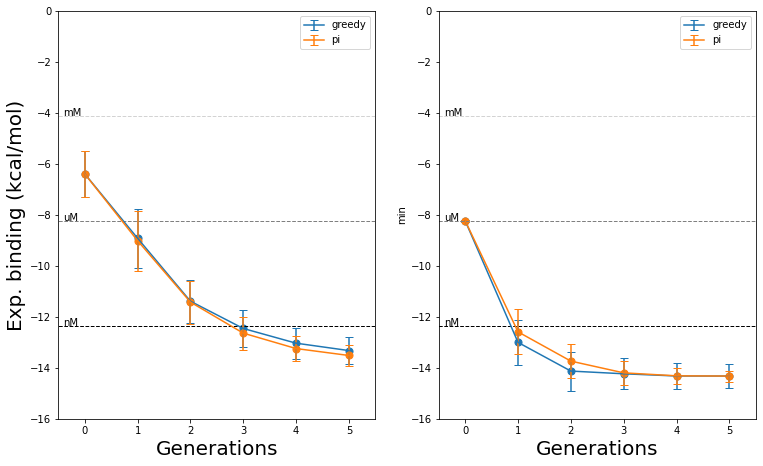

In [35]:
colors = ['tab:blue', 'tab:orange']
labels = ['greedy', 'pi']
plot_results_multi([dfs[k] for k in ['greedy_tanimoto_map4', 'pi_tanimoto_map4']], colors, labels, 'comparison_acq_function')

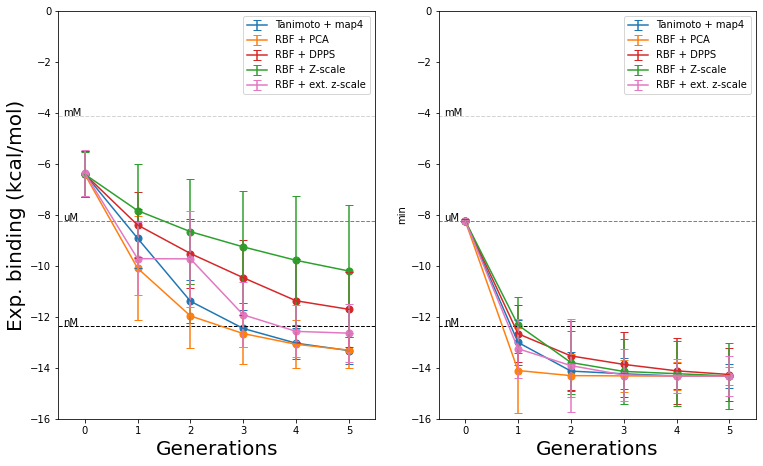

In [36]:
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:pink']
labels = ['Tanimoto + map4', 'RBF + PCA', 'RBF + DPPS', 'RBF + Z-scale', 'RBF + ext. z-scale']
plot_results_multi([dfs[k] for k in ['greedy_tanimoto_map4', 'ei_rbf_pca', 'ei_rbf_dpps', 'ei_rbf_z-scale', 'ei_rbf_extended-z-scale']], colors, labels, 'comparison_descriptors')

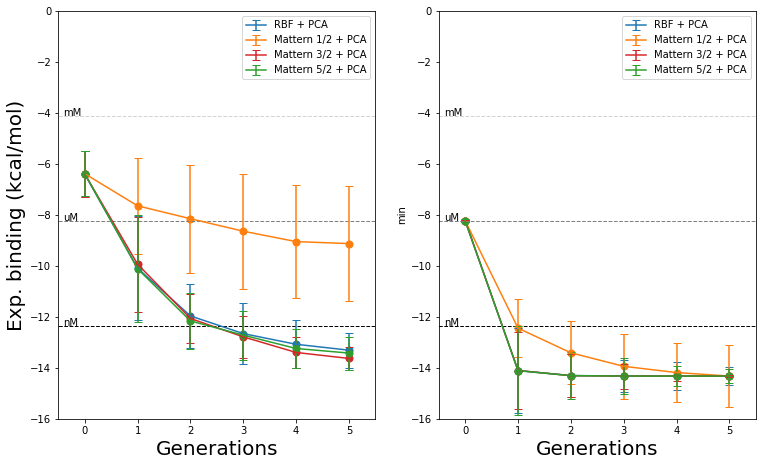

In [37]:
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green']
labels = ['RBF + PCA', 'Mattern 1/2 + PCA', 'Mattern 3/2 + PCA', 'Mattern 5/2 + PCA']
plot_results_multi([dfs[k] for k in ['ei_rbf_pca', 'ei_mattern12_pca', 'ei_mattern32_pca', 'ei_mattern52_pca']], colors, labels, 'comparison_kernels_pca')

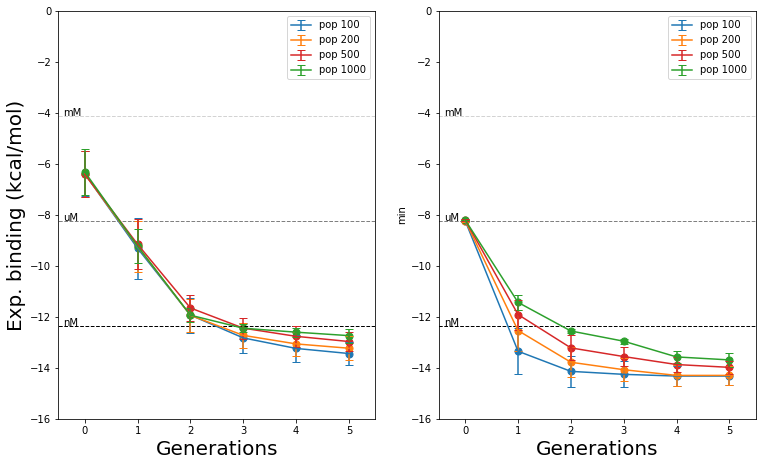

In [43]:
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green']
labels = ['pop 100', 'pop 200', 'pop 500', 'pop 1000']
plot_results_multi([dfs[k] for k in ['ei_tanimoto_map4_pop-100', 'ei_tanimoto_map4_pop-200', 'ei_tanimoto_map4_pop-500', 'ei_tanimoto_map4_pop-1000']], colors, labels, 'comparison_pop-size')

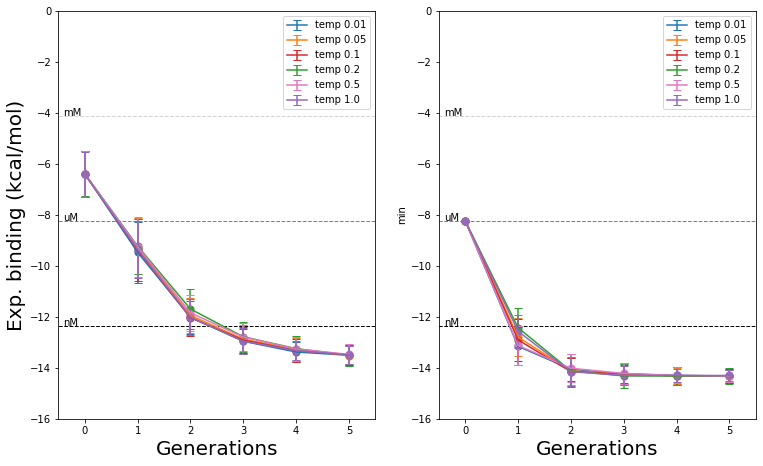

In [45]:
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:pink', 'tab:purple']
labels = ['temp 0.01', 'temp 0.05', 'temp 0.1', 'temp 0.2', 'temp 0.5', 'temp 1.0']
plot_results_multi([dfs[k] for k in ['ei_tanimoto_map4_temp-0.01', 'ei_tanimoto_map4_temp-0.05', 'ei_tanimoto_map4_temp-0.1', 'ei_tanimoto_map4_temp-0.2', 'ei_tanimoto_map4_temp-0.5', 'ei_tanimoto_map4_temp-1.0']], colors, labels, 'comparison_temp')

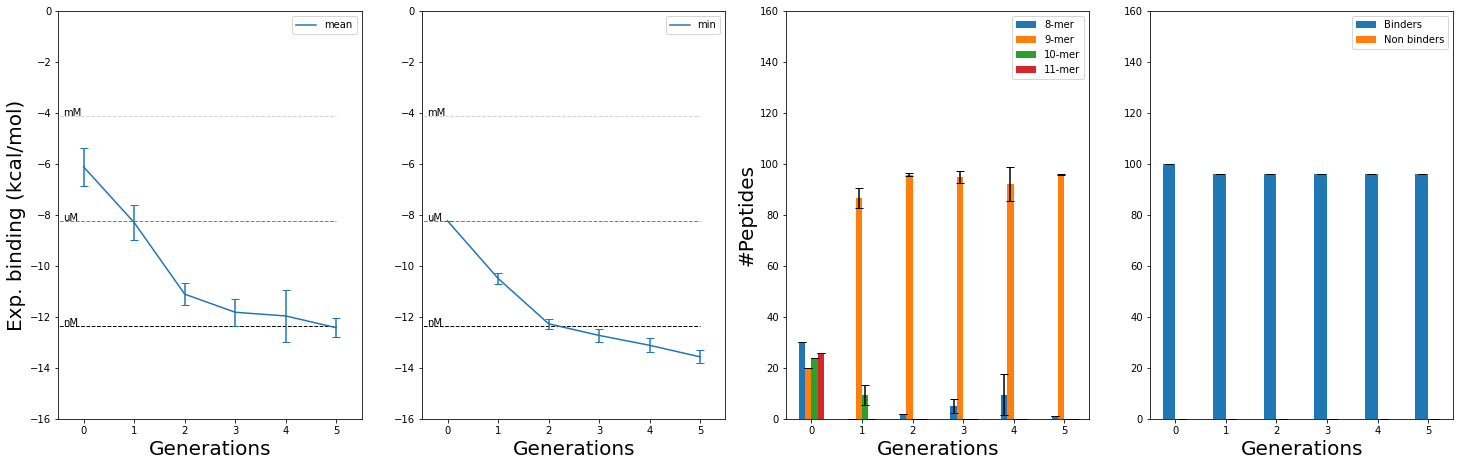

In [48]:
df = pd.read_csv('100-8-9-10-11-mers_SeqGA_ei_tanimoto_map4.csv')
plot_results(df, 'test')

In [7]:
t = df.groupby(by=['gen'])['sequence'].apply(list)

for i in range(6):
    u, c = np.unique(t[i], return_counts=True)
    print(len(u), np.max(c))
    print(c)
    print('')

100 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

452 9
[1 1 2 2 1 1 3 1 3 1 1 2 4 1 2 1 1 1 1 2 1 5 2 2 3 1 1 2 3 2 3 1 1 1 2 3 2
 2 2 2 1 2 2 2 1 1 2 1 3 1 6 2 1 1 1 3 1 8 1 4 1 1 2 5 5 1 2 1 4 5 1 2 5 3
 7 1 1 1 3 7 2 5 1 3 6 4 5 3 5 6 4 7 4 2 1 1 1 1 6 1 2 3 1 6 2 1 2 1 4 1 6
 1 5 4 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 3 2 2 1 2 5 1 3 1 1
 5 4 1 3 2 2 1 3 1 2 1 4 1 1 3 1 1 1 4 1 1 1 1 1 1 1 1 3 6 2 5 1 1 1 3 4 7
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 2
 2 1 1 4 2 2 2 1 1 1 4 1 3 1 3 1 1 1 1 1 1 1 4 1 1 1 1 1 1 2 1 2 3 2 1 5 1
 1 2 1 4 1 2 3 4 1 2 2 1 3 3 1 1 3 8 2 7 1 9 8 1 1 2 5 8 3 1 2 1 5 1 1 1 1
 1 3 1 1 1 1 1 2 7 2 4 3 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 3 1 1 1 4 1 4 1 1 2
 2 1 1 3 1 3 1 1 1 3 2 1 3 1 1 1 1 2 2 1 3 3 3 2 1 2 4 1 6 3 5 1 4 7 3 3 4
 2 2 3 6 3 6 3 1 3 2 5 3 1 5 2 5 

In [8]:
df = pd.read_csv('data_100-9-mers_SeqGA_ei_tanimoto_map4_pop-2000_0.csv')

t = df.groupby(by=['gen'])['sequence'].apply(list)

for i in range(6):
    u, c = np.unique(t[i], return_counts=True)
    print(len(u), np.max(c))
    print(c)
    print('')

100 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

411 8
[2 1 1 2 3 1 1 1 1 4 2 1 1 7 1 1 5 1 2 1 1 3 5 5 1 1 7 5 7 7 3 1 1 1 7 1 4
 4 2 4 6 5 1 1 1 5 6 2 7 5 7 5 4 1 7 7 5 3 7 5 7 5 7 4 7 1 5 2 1 2 1 1 6 5
 2 1 3 4 2 2 1 5 1 1 1 1 1 4 2 1 4 1 1 1 1 2 1 1 1 7 1 1 6 3 4 2 1 1 1 1 1
 1 1 1 1 2 3 2 1 2 2 1 4 1 1 1 1 4 1 1 1 1 3 4 1 1 1 2 6 2 5 7 4 4 6 5 1 1
 2 6 1 2 4 1 4 1 1 2 1 5 3 1 2 4 1 4 3 1 1 1 3 1 1 4 2 1 1 1 1 6 1 1 2 2 2
 1 2 1 2 2 2 2 1 7 1 6 1 4 2 4 5 2 7 2 2 2 1 2 1 1 2 2 2 1 1 1 2 1 1 1 2 1
 1 1 1 3 1 1 2 1 2 2 1 1 2 4 1 5 1 1 1 2 3 2 4 1 1 1 1 1 2 3 1 2 1 2 2 1 1
 1 3 1 2 1 3 1 6 2 2 2 1 2 1 1 2 2 1 1 2 2 4 1 2 1 4 3 1 2 1 1 1 1 1 2 2 1
 2 1 1 1 7 1 1 1 1 7 1 1 5 8 2 3 8 6 8 8 1 1 4 4 1 1 4 1 1 2 1 1 3 1 2 3 3
 1 3 1 1 1 2 1 2 3 4 4 2 3 1 6 7 5 1 6 1 7 4 1 2 3 3 2 3 5 1 1 1 2 2 1 2 4
 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 